In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Define our imshow function 
def imshow(title = "Image", image = None, size = 10):
    w, h = image.shape[0], image.shape[1]
    aspect_ratio = w/h
    plt.figure(figsize=(size * aspect_ratio,size))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.show()

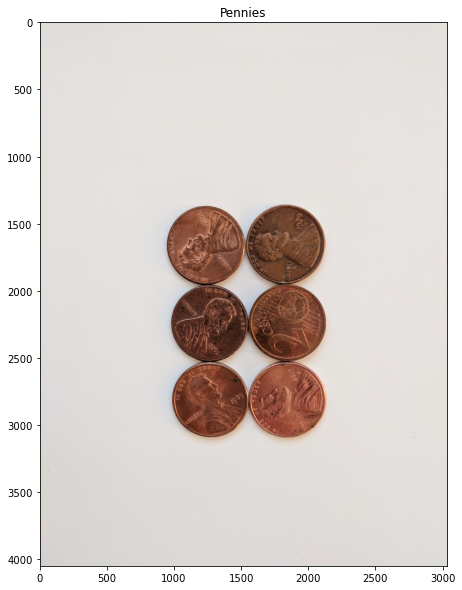

In [5]:
img = cv2.imread('images/pennies.jpg')
imshow("Pennies",img)

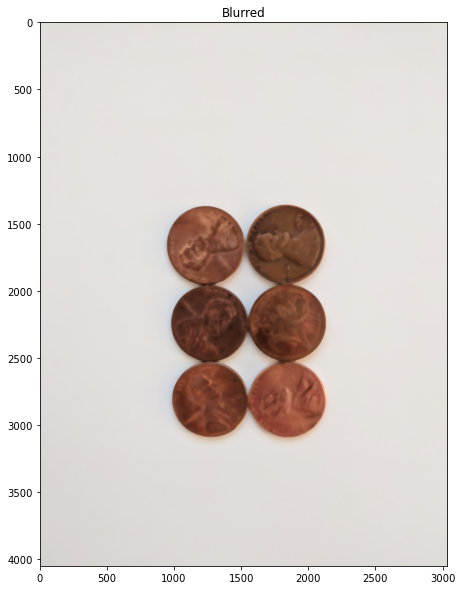

In [7]:
# Median blur to get rid of unnecessary details like faces on pennies
# Grayscale and threshold
# Find the contours
blurred = cv2.medianBlur(img,25)
imshow("Blurred", blurred)

In [12]:
gray = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY)

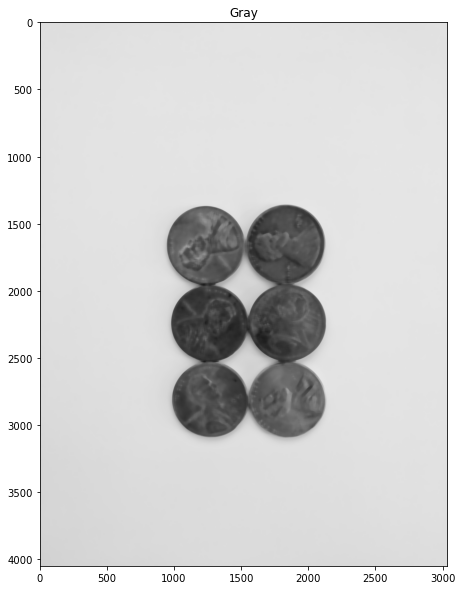

In [14]:
imshow("Gray", gray)

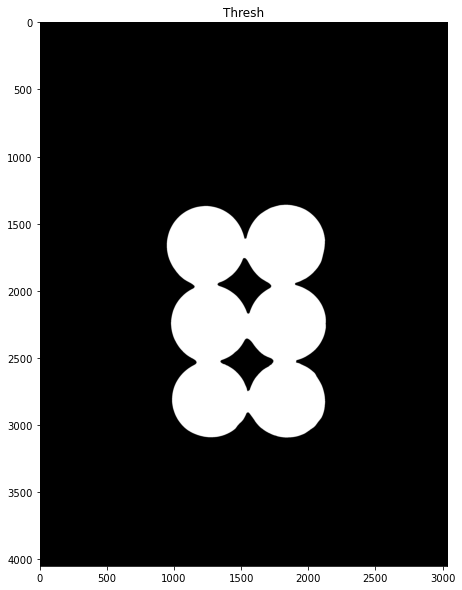

In [15]:
ret, thresh = cv2.threshold(gray, 160, 255, cv2.THRESH_BINARY_INV) # 127 mid value causes distortion
imshow("Thresh", thresh)

In [24]:
contours,hierarchy = cv2.findContours(thresh.copy(),cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

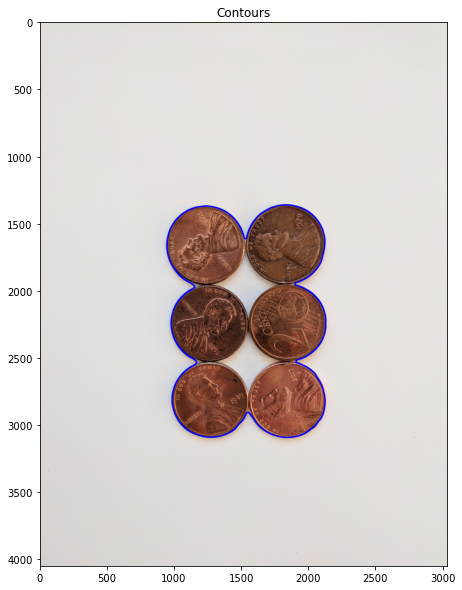

In [23]:
for i in range(len(contours)):
    if hierarchy[0][i][3] == -1:
        cv2.drawContours(img,contours,i,(255,0,0),10)
imshow("Contours", img)

In [25]:
kernel = np.ones((3,3), np.uint8)

In [26]:
# Noise removal - optional
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

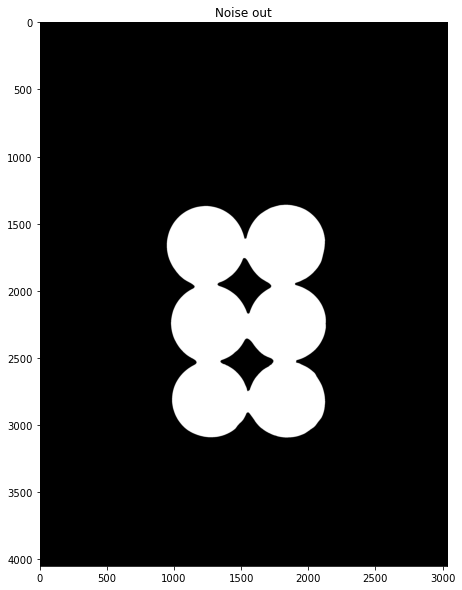

In [27]:
imshow("Noise out", opening) #Coins still touching each other

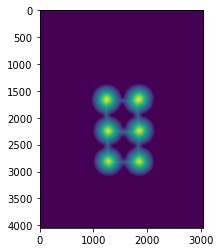

In [31]:
# Set seeds for the foreground to separate them from background
# Distance transfrom - as we move away from 0/black it gets brighter
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2,5)
plt.imshow(dist_transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


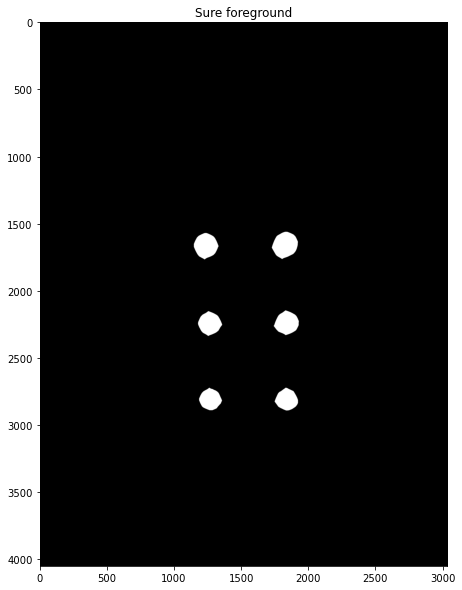

In [34]:
ret, sure_fg = cv2.threshold(dist_transform, 0.7*dist_transform.max(),255,0)
imshow("Sure foreground", sure_fg) 

In [35]:
# Sure background
sure_bg = cv2.dilate(opening, kernel, iterations=3)

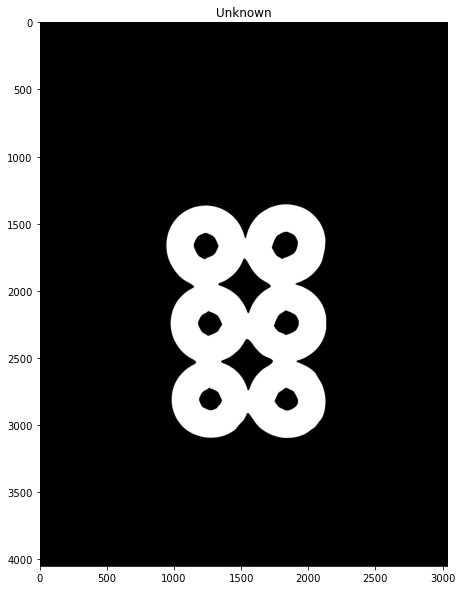

In [37]:
# There is still unknown region bright areas should have been bigger
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)
imshow("Unknown", unknown)

In [38]:
# Create markers for watershed algorithm
ret,markers = cv2.connectedComponents(sure_fg)

In [39]:
markers

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

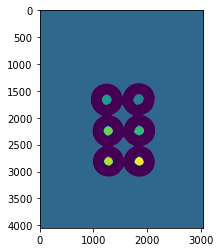

In [42]:
# Add 1 so that sure_bg is not zero but 1 so we can mark the unknown region with zero 
# Unknown region - doughnuts that we are not sure if they belong to the fg or bg
markers = markers + 1
markers[unknown==255] = 0
plt.imshow(markers)

In [43]:
markers = cv2.watershed(img, markers)

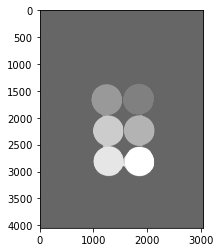

In [45]:
plt.imshow(markers, cmap='gray')

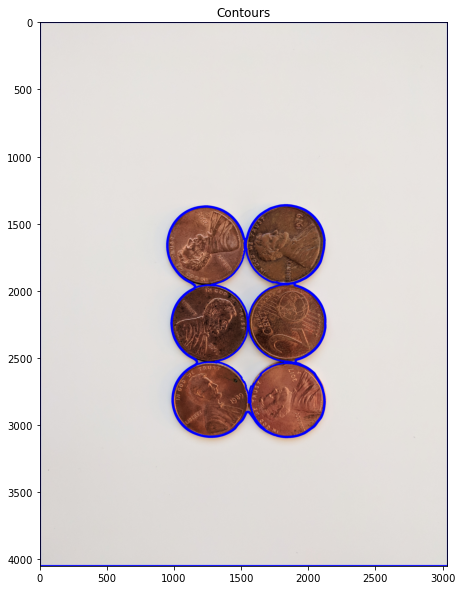

In [46]:
contours,hierarchy = cv2.findContours(markers.copy(),cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
for i in range(len(contours)):
    if hierarchy[0][i][3] == -1:
        cv2.drawContours(img,contours,i,(255,0,0),10)
imshow("Contours", img)